In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings("ignore")

from src.model.lstm_samadhi import LstmSamadhiModel
from src.train.anomaly_trainer import AnomalySamadhiTrainer

from sklearn.metrics import (
    precision_recall_curve,
    auc,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "../data/sensor.csv"
BATCH_SIZE = 256
EPOCHS_PRETRAIN = 10
EPOCHS_MAIN = 10
LATENT_DIM = 32
N_PROBES = 10
SEQ_LEN = 30
INPUT_DIM = None

CONFIG = {
    "dim": LATENT_DIM,
    "input_dim": INPUT_DIM,
    "seq_len": SEQ_LEN,
    "n_probes": N_PROBES,
    "refine_steps": 5,
    "softmax_temp": 0.5,
    "gate_threshold": 0.5,
    "stability_coeff": 0.1,
    "entropy_coeff": 0.05,
    "balance_coeff": 1.0,
    "mix_alpha": 0.5,
    "probe_trainable": True,
    "vicara_type": "standard",
    "adapter_hidden_dim": 128,
    "lstm_layers": 2,
    "training_attention_mode": "soft",
    "prediction_attention_mode": "hard",
    "anomaly_margin": 2.0,
    "anomaly_weight": 1.0,
}

In [2]:
def create_sequences(data, seq_len):
    xs = []
    for i in range(len(data) - seq_len + 1):
        xs.append(data[i : (i + seq_len)])
    return np.array(xs)

def load_time_series_data_semi_supervised(path, seq_len):
    print(f"Loading time series data from {path}...")
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        df = pd.read_csv("../" + path)

    # 1. Handle Labels (machine_status)
    if 'machine_status' in df.columns:
        print("Found 'machine_status' column. Encoding labels...")
        # Map NORMAL to 0, BROKEN/RECOVERING to 1
        df['label'] = df['machine_status'].apply(lambda x: 0 if x == 'NORMAL' else 1)
        labels = df['label'].values
    else:
        print("Warning: No 'machine_status' column found. Assuming all data is normal for now.")
        labels = np.zeros(len(df))

    # 2. Drop unnecessary columns from features_df
    cols_to_drop = ['Unnamed: 0', 'timestamp', 'machine_status', 'label', 'Class']
    if 'sensor_15' in df.columns:
        cols_to_drop.append('sensor_15')

    features_df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # 3. Handle Missing Values in remaining features
    features_df = features_df.fillna(method='ffill').fillna(0)

    # Ensure only numeric columns remain (after dropping timestamp etc.)
    numeric_cols = features_df.select_dtypes(include=np.number).columns.tolist()
    features_df = features_df[numeric_cols]

    print(f"Features shape after preprocessing: {features_df.shape}")

    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)

    # Create sequences
    sequences = create_sequences(scaled_features, seq_len)
    sequence_labels = labels[seq_len - 1 :]

    # Determine INPUT_DIM after scaling and feature selection
    global INPUT_DIM
    INPUT_DIM = sequences.shape[-1]
    CONFIG["input_dim"] = INPUT_DIM
    print(f"Detected INPUT_DIM: {INPUT_DIM}, SEQ_LEN: {SEQ_LEN}")

    # Convert to PyTorch tensors
    X = torch.tensor(sequences, dtype=torch.float32)
    y = torch.tensor(sequence_labels, dtype=torch.long)

    # --- 時系列データの時間順でのTrain/Test分割 ---
    split_train_end_idx = 110000
    split_test_end_idx = 150000

    X_train = X[:split_train_end_idx]
    y_train = y[:split_train_end_idx]

    X_test = X[split_train_end_idx:split_test_end_idx]
    y_test = y[split_train_end_idx:split_test_end_idx]

    # 分割後の正常/異常シーケンス数を表示
    train_normal_count = (y_train == 0).sum().item()
    train_anomaly_count = (y_train == 1).sum().item()
    test_normal_count = (y_test == 0).sum().item()
    test_anomaly_count = (y_test == 1).sum().item()

    print(f"Train (Time-split): Normal={train_normal_count}, Anomaly={train_anomaly_count}")
    print(f"Test (Time-split) : Normal={test_normal_count}, Anomaly={test_anomaly_count}")

    # Warn if train/test anomaly counts are too low
    if train_anomaly_count == 0:
        print("Warning: No anomaly samples in training set after time-based split. Model will learn purely unsupervised on normal data.")
    if test_anomaly_count == 0:
        print("Warning: No anomaly samples in test set after time-based split. Cannot evaluate anomaly detection performance.")
    elif test_anomaly_count < 50:
        print(f"Warning: Very few anomaly samples ({test_anomaly_count}) in test set. Evaluation metrics might be unreliable.")

    return X_train, y_train, X_test, y_test

In [3]:
def create_dataloader(X, y, batch_size=BATCH_SIZE, shuffle=True):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def evaluate_model(model, dataloader, y_true):
    model.eval()
    device = next(model.parameters()).device

    reconstruction_errors = []
    confidences = []
    winner_probes = []
    gate_opens = []

    print("Evaluating with Gate Check...")
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)

            s0, meta = model.vitakka(x)

            conf = meta["confidence"]
            winner = meta["winner_id"]
            is_open = meta["gate_open"]

            s_final, _, _ = model.vicara(s0, context=meta)

            x_recon = model.decoder(s_final)

            # MSE per sequence (Batch, Seq_Len, Features) -> (Batch)
            mse = torch.mean((x - x_recon) ** 2, dim=[1, 2])

            reconstruction_errors.append(mse.cpu())
            confidences.append(conf.cpu())
            winner_probes.append(winner.cpu())
            gate_opens.append(is_open.cpu())

    recon_errs = torch.cat(reconstruction_errors).numpy()
    confs = torch.cat(confidences).numpy()
    winners = torch.cat(winner_probes).numpy()
    gates = torch.cat(gate_opens).numpy()

    # Gating Analysis
    print("\n--- Gating Analysis ---")
    normal_passed = np.sum(gates[y_true == 0])
    normal_total = np.sum(y_true == 0)
    print(f"Normal: {normal_passed}/{normal_total} passed ({normal_passed/normal_total:.2%})")

    fraud_passed = np.sum(gates[y_true == 1])
    fraud_total = np.sum(y_true == 1)
    print(f"Fraud : {fraud_passed}/{fraud_total} passed ({fraud_passed/fraud_total:.2%})")

    return recon_errs, confs, winners, gates


def analyze_and_plot_results(y_true, recon_errs, confs, winners, gates):
    print("\n--- Detailed Analysis ---")

    # 1. Mean Stats
    print(f"{'Class':<10} | {'Mean Recon Err':<15} | {'Mean Conf':<10}")
    print("-" * 45)
    print(f"{'Normal':<10} | {np.mean(recon_errs[y_true==0]):<15.4f} | {np.mean(confs[y_true==0]):<10.4f}")
    print(f"{'Fraud':<10} | {np.mean(recon_errs[y_true==1]):<15.4f} | {np.mean(confs[y_true==1]):<10.4f}")

    # 2. Probe Usage
    print("\n--- Probe Usage Distribution ---")
    n_probes = CONFIG["n_probes"]
    normal_winners = winners[y_true == 0]
    normal_counts = np.bincount(normal_winners, minlength=n_probes)
    normal_probs = normal_counts / (len(normal_winners) + 1e-10)

    fraud_winners = winners[y_true == 1]
    fraud_counts = np.bincount(fraud_winners, minlength=n_probes)
    fraud_probs = fraud_counts / (len(fraud_winners) + 1e-10)

    print(f"{'Probe ID':<8} | {'Normal Usage (%)':<18} | {'Fraud Usage (%)':<18}")
    print("-" * 50)
    for i in range(n_probes):
        print(f"{i:<8} | {normal_probs[i]*100:<18.2f} | {fraud_probs[i]*100:<18.2f}")

    # 3. ROC-AUC
    roc_recon = roc_auc_score(y_true, recon_errs)
    print("\n--- ROC-AUC Scores ---")
    print(f"Reconstruction Error (Higher is Anomaly): {roc_recon:.4f}")

    # 4. Classification Report (Optimizing Threshold by F1)
    print("\n--- Classification Performance (Reconstruction Error) ---")
    precision, recall, thresholds = precision_recall_curve(y_true, recon_errs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"Best Threshold (F1-Max): {best_threshold:.4f}")

    y_pred = (recon_errs > best_threshold).astype(int)
    print(classification_report(y_true, y_pred, target_names=["Normal", "Fraud"]))
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")

    # 5. Visualization
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    sns.kdeplot(recon_errs[y_true == 0], fill=True, label="Normal")
    sns.kdeplot(recon_errs[y_true == 1], fill=True, label="Fraud")
    plt.title("Reconstruction Error Density")
    plt.xlabel("MSE Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    sns.kdeplot(confs[y_true == 0], fill=True, label="Normal")
    sns.kdeplot(confs[y_true == 1], fill=True, label="Fraud")
    plt.title("Confidence Density")
    plt.xlabel("Confidence Score")
    plt.legend()

    plt.subplot(1, 3, 3)
    idx_normal = np.where(y_true == 0)[0]
    if len(idx_normal) > 5000:
        idx_normal = np.random.choice(idx_normal, 5000, replace=False)
    idx_fraud = np.where(y_true == 1)[0]

    plt.scatter(confs[idx_normal], recon_errs[idx_normal], alpha=0.3, label="Normal", s=10)
    plt.scatter(confs[idx_fraud], recon_errs[idx_fraud], alpha=0.6, label="Fraud", s=20, color="red")
    plt.title("Confidence vs Reconstruction Error")
    plt.xlabel("Confidence")
    plt.ylabel("Reconstruction Error")
    plt.legend()

    plt.tight_layout()
    plt.show()
    return best_threshold

In [4]:
# --- Main Execution ---
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Load and prepare data
X_train, y_train, X_test, y_test = load_time_series_data_semi_supervised(DATA_PATH, SEQ_LEN)

# Update CONFIG with actual INPUT_DIM
CONFIG["input_dim"] = INPUT_DIM

# Create DataLoaders
# For pretraining, create a DataLoader with NORMAL data only
X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0]
train_autoencoder_loader = create_dataloader(X_train_normal, y_train_normal, shuffle=True)

# Main training dataloader includes both normal and anomaly
train_loader = create_dataloader(X_train, y_train, shuffle=True)
test_loader = create_dataloader(X_test, y_test, shuffle=False)

# Model and Trainer setup
model = LstmSamadhiModel(CONFIG).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = AnomalySamadhiTrainer(model, optimizer)


Using device: mps
Loading time series data from ../data/sensor.csv...
Found 'machine_status' column. Encoding labels...
Features shape after preprocessing: (220320, 51)
Detected INPUT_DIM: 51, SEQ_LEN: 30
Train (Time-split): Normal=104025, Anomaly=5975
Test (Time-split) : Normal=31567, Anomaly=8433
Trainer initialized on device: mps


In [5]:
# 1. Pretrain Autoencoder with Normal Data Only
trainer.pretrain_autoencoder(train_autoencoder_loader, epochs=EPOCHS_PRETRAIN)



==================== Starting Autoencoder Pre-training (Normal Only) ====================
Pre-train Epoch 1/10, Avg Recon Loss (Normal): 0.2843
Pre-train Epoch 2/10, Avg Recon Loss (Normal): 0.1910
Pre-train Epoch 3/10, Avg Recon Loss (Normal): 0.1644
Pre-train Epoch 4/10, Avg Recon Loss (Normal): 0.1571
Pre-train Epoch 5/10, Avg Recon Loss (Normal): 0.1389
Pre-train Epoch 6/10, Avg Recon Loss (Normal): 0.1323
Pre-train Epoch 7/10, Avg Recon Loss (Normal): 0.1214
Pre-train Epoch 8/10, Avg Recon Loss (Normal): 0.1149
Pre-train Epoch 9/10, Avg Recon Loss (Normal): 0.1024
Pre-train Epoch 10/10, Avg Recon Loss (Normal): 0.0944
==================== Autoencoder Pre-training Complete ====================



In [6]:

# 2. Init Probes (using Normal Data from Pretrain DataLoader)
print("\n--- Initializing Probes with Normal Data ---")
model.eval()
latents = []
with torch.no_grad():
    for batch in train_autoencoder_loader:
        x, _ = batch
        x = x.to(device)
        z = model.vitakka.adapter(x)
        latents.append(z.cpu().numpy())

latents = np.concatenate(latents, axis=0)
# Subsample for KMeans if too large
if len(latents) > 10000:
    indices = np.random.choice(len(latents), 10000, replace=False)
    latents_sub = latents[indices]
else:
    latents_sub = latents

kmeans = KMeans(n_clusters=CONFIG["n_probes"], random_state=42, n_init='auto') # Added n_init='auto' for modern sklearn
kmeans.fit(latents_sub)
centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)
model.load_probes(centroids)
print("Probes initialized.")


--- Initializing Probes with Normal Data ---
Probes initialized.


In [7]:
# 3. Main Training (With Margin Loss)
trainer.fit(train_loader, epochs=EPOCHS_MAIN)



--- Start Anomaly Training (Margin Loss) ---
Device: mps
Params: Margin=2.0, Anomaly Weight=1.0
Epoch 1/10 | Batch 400 | Loss: 0.3014
Epoch 1 Finished. Avg Loss: 0.3454
Epoch 2/10 | Batch 400 | Loss: 0.2386
Epoch 2 Finished. Avg Loss: 0.2543
Epoch 3/10 | Batch 400 | Loss: 0.1497
Epoch 3 Finished. Avg Loss: 0.2030
Epoch 4/10 | Batch 400 | Loss: 0.1806
Epoch 4 Finished. Avg Loss: 0.1966
Epoch 5/10 | Batch 400 | Loss: 0.2253
Epoch 5 Finished. Avg Loss: 0.1912
Epoch 6/10 | Batch 400 | Loss: 0.1871
Epoch 6 Finished. Avg Loss: 0.2167
Epoch 7/10 | Batch 400 | Loss: 0.2326
Epoch 7 Finished. Avg Loss: 0.1875
Epoch 8/10 | Batch 400 | Loss: 0.1846
Epoch 8 Finished. Avg Loss: 0.1753
Epoch 9/10 | Batch 400 | Loss: 0.2024
Epoch 9 Finished. Avg Loss: 0.1642
Epoch 10/10 | Batch 400 | Loss: 0.1740
Epoch 10 Finished. Avg Loss: 0.1644


[0.3454483143118925,
 0.25434816101955815,
 0.2029627486023792,
 0.19655944881744164,
 0.19118992920185243,
 0.2167319269027821,
 0.18752221879224445,
 0.1752836896409822,
 0.16421138375651004,
 0.1644314781524414]


--- Evaluation on Test Data ---
Evaluating with Gate Check...

--- Gating Analysis ---
Normal: 31482/31567 passed (99.73%)
Fraud : 8433/8433 passed (100.00%)

--- Detailed Analysis ---
Class      | Mean Recon Err  | Mean Conf 
---------------------------------------------
Normal     | 0.5754          | 0.2275    
Fraud      | 4.4729          | 0.6501    

--- Probe Usage Distribution ---
Probe ID | Normal Usage (%)   | Fraud Usage (%)   
--------------------------------------------------
0        | 0.00               | 0.00              
1        | 2.55               | 99.95             
2        | 2.72               | 0.00              
3        | 0.93               | 0.00              
4        | 1.86               | 0.00              
5        | 7.68               | 0.05              
6        | 75.21              | 0.00              
7        | 5.19               | 0.00              
8        | 1.83               | 0.00              
9        | 2.04               | 0.00           

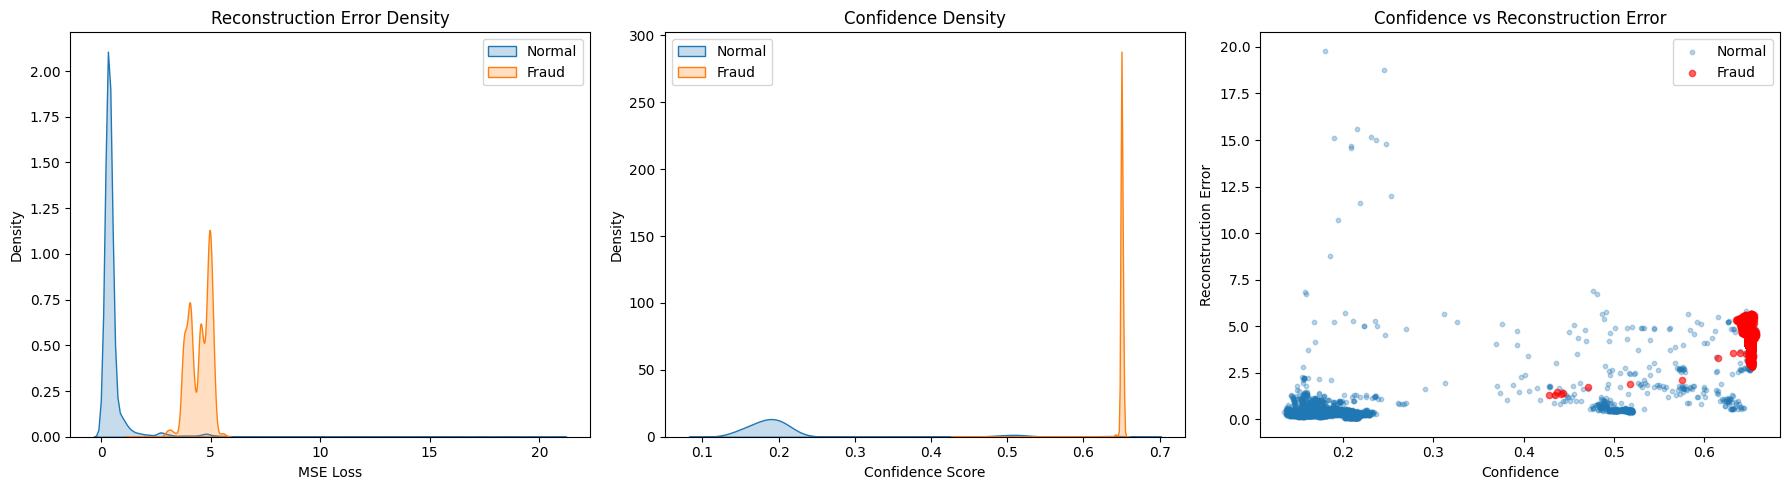


--- Final Classification Performance on Test Data ---
Mean Recon Error (Normal): 0.5754
Mean Recon Error (Fraud) : 4.4729
Ratio (Fraud/Normal)     : 7.77x
ROC-AUC: 0.9849
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     31567
       Fraud       0.91      0.99      0.95      8433

    accuracy                           0.98     40000
   macro avg       0.95      0.98      0.97     40000
weighted avg       0.98      0.98      0.98     40000

Confusion Matrix:
[[30744   823]
 [   51  8382]]


In [8]:
# 4. Evaluate on Test Data and analyze results
print("\n--- Evaluation on Test Data ---")
recon_errs_test, confs_test, winners_test, gates_test = evaluate_model(model, test_loader, y_test.numpy())

# Analyze and plot results, determining best threshold based on F1 score on test data
best_threshold = analyze_and_plot_results(y_test.numpy(), recon_errs_test, confs_test, winners_test, gates_test)

print("\n--- Final Classification Performance on Test Data ---")
y_pred_test = (recon_errs_test > best_threshold).astype(int)

y_true_test = y_test.numpy()
normal_err_test = np.mean(recon_errs_test[y_true_test == 0])
fraud_err_test = np.mean(recon_errs_test[y_true_test == 1])
roc_test = roc_auc_score(y_true_test, recon_errs_test)

print(f"Mean Recon Error (Normal): {normal_err_test:.4f}")
print(f"Mean Recon Error (Fraud) : {fraud_err_test:.4f}")
print(f"Ratio (Fraud/Normal)     : {fraud_err_test/normal_err_test:.2f}x")
print(f"ROC-AUC: {roc_test:.4f}")

print(classification_report(y_true_test, y_pred_test, target_names=["Normal", "Fraud"]))
print(f"Confusion Matrix:\n{confusion_matrix(y_true_test, y_pred_test)}")